<a href="https://colab.research.google.com/github/gizdatalab/CPU/blob/main/classifiers/SUBTARGET/CPU_SUBTARGET_bge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETFIT Ver 1.0.1:  


*   [How-to Guide](https://huggingface.co/docs/setfit/how_to/overview)
*   [Sampling Strategies](https://huggingface.co/docs/setfit/conceptual_guides/sampling_strategies)
*   [Setfit Conceptual Guide](https://huggingface.co/docs/setfit/conceptual_guides/setfit)

In [ ]:
!pip install sentence-transformers setfit dataset
!pip install umap-learn hdbscan
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.27
    Uninstalling SQLAlchemy-2.0.27:
      Successfully uninstalled SQLAlchemy-2.0.27
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [ ]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 00:29:58] [setup] RAM Tracking...
[codecarbon INFO @ 00:29:58] [setup] GPU Tracking...
[codecarbon INFO @ 00:29:58] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:29:58] [setup] CPU Tracking...
[codecarbon WARNING @ 00:29:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:30:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:30:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 00:30:00] >>> Tracker's metadata:
[codecarbon INFO @ 00:30:00]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 00:30:00]   Python version: 3.10.12
[codecarbon INFO @ 00:30:00]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 00:30:00]   Available RAM : 12.675 GB
[codecarbon INFO @ 00:30:00]   CPU count: 2
[codecarbon INFO @ 00:30:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 00:30:00]   GPU c

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
# from setfit import SetFitModel, SetFitTrainer,sample_dataset
# from sentence_transformers import SentenceTransformer, InputExample, losses, models
# from sentence_transformers.losses.BatchHardTripletLoss import \
#     BatchHardTripletLossDistanceFunction
import datasets
import pandas as pd
import ast
import numpy as np
from typing import Dict, List, Optional, Set, Tuple, Union, Literal
from setfit import TrainingArguments
from setfit import Trainer
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    IntervalStrategy,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from setfit import SetFitModel, TrainingArguments

from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.losses.BatchHardTripletLoss import \
    BatchHardTripletLossDistanceFunction

# from skmultilearn.model_selection import iterative_train_test_split
# from skmultilearn.model_selection import IterativeStratification
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# to set the device type, if using GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import umap.umap_ as umap

# Manual Input Steps

In [ ]:
################ Define the important variables (Load and Process data) #######

# path to data folder
repo_id = "GIZ/policy_classification"
train_file="policy_classification_train.json"
test_file="policy_classification_test.json"

label_names= ['NetzeroLabel','GHGLabel','NonGHGLabel']
label_names.sort()
# Map the columns which need to be processesed. i.e column which contains 'text' for
# prediciton and label column  for ground truth.
text_column = 'text'
label_column = 'label'



############# Define the Parameters for the Model to be used ##################

# Model to be used for Sentence Embedding
model_id = "BAAI/bge-base-en-v1.5"

# USE DENSE ( Setfit Head) or NOT, If not Scikit Learn head will be used
use_differentiable_head=True
# normalize the embedding or not
normalize_embeddings: bool = True


############## Define Training Arguments   ########################

# batch sizes and epochs for the embedding and classifier training phases
# respectively, or set both if an integer is provided. Note that the batch
# size for the classifier is only used with a differentiable PyTorch head.
batch_size= (16,2)

# we keep the epochs=0 for classiifier stage as we will do the Classifier Trianing
# on our own using separate method, this is done to insure the we have control
# over the classifier trianing phase and look at metrics to guage if
# overfitting or underfititng
num_epochs = (1,0)


# we need it for our own custom Classifier training
classifier_num_epochs = 5


# for multi-class and multilabel dataset we will usually
# have positive class in minority there fore maybe a good
# option to try, rather than model getting focused too much
# on negative class.
# [''oversampling'.'undersampling, 'unique'], Default = 'oversampling'
sampling_strategy = 'undersampling'

# Set the learning rate for the SentenceTransformer body for the embedding and
# classifier training phases respectively, or set both if a float is provided.
# Note that the body learning rate for the classifier is only used with a
# differentiable PyTorch head and if end_to_end=True.
body_learning_rate = (6.86e-06, 0.00001)
head_learning_rate = 0.01


loss = losses.CosineSimilarityLoss

# to be used only for triplet loss categories
# distance_metric = losses.BatchHardTripletLossDistanceFunction.cosine_distance,

#  log and evlautions strategy and steps
# Strategy possible vlaues: ["steps","epochs","no"]
logging_strategy = "steps"
evaluation_strategy = "steps"
logging_steps = 20
eval_steps=20

# # to be used for triplet loss category
# margin = 0.25

## to be used with differential head
end_to_end = False
# if use_differentiable_head == True:
#     end_to_end = True
# else: end_to_end = False

warmup_proportion = 0.01

## to be used for triplet loss only
# samples_per_label = 2

# output dir, if you push the mdoel to hub then this will be name of model
output_dir = "subtarget_multilabel_bge"


# method to use for embedding dimentionality reduction
method = 'umap'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Automated

## Load & Sample Data

In [ ]:
# Load Dataset from Hugging Face
data_files = {"train": train_file, "test": test_file}
dataset = load_dataset(repo_id, data_files=data_files)

# the dataset already contains train_test split flag we use
# it to create train-test split.

df_train = dataset['train'].to_pandas()
df_test =dataset['test'].to_pandas()

# Sort the labels and create plaecholders for id2label and label2id
label_names.sort()

num_labels = len(label_names)
id2label = {idx:label for idx, label in enumerate(label_names)}
label2id = {label:idx for idx, label in enumerate(label_names)}
print(id2label)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{0: 'GHGLabel', 1: 'NetzeroLabel', 2: 'NonGHGLabel'}


In [ ]:
def prepare_multilabel_df(df, cols):
    """
    Takes the dataframe and list of columns which need to combined into
    One-hot-encoded labels.

    """
    df.dropna(subset = cols, inplace=True)
    df = df.reset_index(drop=True)
    df['labels'] = df.apply(lambda x: [int(x[label]) for label in cols],axis=1)
    # we have multilingual dataset ('en', 'fr','es'), in case of non-english the
    # translated Context is udner the column 'TranslatedContext'. We impute these
    # back into 'context' to work with only English dataset.
    df['Context'] = df.apply(lambda x: x['Context'] if x['Language'] == 'en'
                                    else x['TranslatedContext'][0],axis=1)
    df.rename(columns = {'Context':'text','labels':'label'}, inplace=True)

    df = df[['text','label']+cols]
    return df

# creating multilabel dataset
df_train = prepare_multilabel_df(df_train, label_names)
df_test = prepare_multilabel_df(df_test, label_names)

print('\n','Classes Representation in Training Dataset:',len(df_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(df_train['label'])]))

print('\n','Classes Representation in Test Dataset:',len(df_test))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(df_test['label'])]))

train_ds = datasets.Dataset.from_pandas(df_train)
test_ds = datasets.Dataset.from_pandas(df_test)


 Classes Representation in Training Dataset: 728
0 . GHGLabel : 440
1 . NetzeroLabel : 120
2 . NonGHGLabel : 259

 Classes Representation in Test Dataset: 80
0 . GHGLabel : 49
1 . NetzeroLabel : 11
2 . NonGHGLabel : 30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

In [ ]:
def prepare_categorical_multilabel(df):
    # make the copy of dataframe
    df = df.copy()
    # adding the new column which will have the label as category
    # Ex: originally labels were
    df['categorical_label'] = df.label.apply(lambda x: [i*j for i,j in enumerate(x) if j==1])
    df = df.explode('categorical_label')
    df = df.reset_index(drop=True)
    # display(df)
    # we add the labels as text also just in case we need it later
    df = df.dropna(subset = ['categorical_label'])
    df = df.reset_index(drop=True)
    df['label_text'] = df.categorical_label.apply(lambda x: id2label[x])

    return df

df_train_explode = prepare_categorical_multilabel(df_train)
print("Training data after explode:", len(df_train_explode))
df_test_explode = prepare_categorical_multilabel(df_test)
print("Test data after explode:", len(df_test_explode))

Training data after explode: 819
Test data after explode: 90


## Metrics

https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea

In [ ]:
import evaluate
# multilabel_accuracy_metric = evaluate.load("accuracy", "multilabel")
multilabel_f1_metric = evaluate.load("f1", "multilabel")
multilabel_recall_metric = evaluate.load("recall","multilabel")
multilabel_precision_metric = evaluate.load("precision","multilabel")

In [ ]:
def compute_metrics(y_pred, y_test):
    """
    Takes the Predictions and Truth Values, and return multilabel metrics
    aggregated on multiple strategies['micro', 'sample', 'weighted']

    """

    return {
        "precision-micro": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="micro")["precision"],
        "precision-samples": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="samples")["precision"],
        "precision-weighted": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="weighted")["precision"],
        "recall-micro": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="micro")["recall"],
        "recall-samples": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="samples")["recall"],
        "recall-weighted": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="weighted")["recall"],
        "f1-micro": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="micro")["f1"],
        "f1-samples": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="samples")["f1"],
        "f1-weighted": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="weighted")["f1"],
    }

## Model

In [ ]:
if use_differentiable_head == True:
    model = SetFitModel.from_pretrained(
                      model_id,
                      multi_target_strategy="one-vs-rest",labels = label_names,
                      device= device,
                      normalize_embeddings = normalize_embeddings,
                      use_differentiable_head=use_differentiable_head,
                      head_params={"out_features": num_labels})
else:
    model = SetFitModel.from_pretrained(
              model_id,
              multi_target_strategy="one-vs-rest", device= device,
              normalize_embeddings = normalize_embeddings,
              labels = label_names)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


## Training Arguments

In [ ]:
args = TrainingArguments(
    output_dir = output_dir,
    batch_size = batch_size,
    num_epochs = num_epochs,
    sampling_strategy = sampling_strategy,
    body_learning_rate = body_learning_rate,
    head_learning_rate = head_learning_rate,
    loss = loss,
    end_to_end = end_to_end,
    warmup_proportion = warmup_proportion,
    logging_strategy=logging_strategy,
    logging_steps = logging_steps,
    eval_steps=eval_steps,
    evaluation_strategy = evaluation_strategy,
)

## Callbacks

In [ ]:
def umap_embed(embeddings, n_neighbors = 15, n_dim = 2, eval_embeddings = None):
    """
    Method to use UMAP to compress the embeddings into n_dim dimensions

    """
    umap_model = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_dim,
                                metric='cosine',
                                random_state=42))
    train_embed = umap_model.fit_transform(embeddings.cpu())

    train_umap = pd.DataFrame()
    for i in range(n_dim):
        train_umap[f'dim_{i+1}'] = train_embed[:,i]
    if eval_embeddings is not None:
        eval_embed = umap_model.transform(eval_embeddings.cpu())
        eval_umap = pd.DataFrame()
        for i in range(n_dim):
            eval_umap[f'dim_{i+1}'] = eval_embed[:,i]

        return train_umap, eval_umap
    return train_umap, None


def tnse_embed(train_embeddings,n_neighbors = 15, n_dim = 2):
    """
    Method to use TSNE to compress the embeddings into n_dim dimensions
    ####### NOTE Why not FIT_TRansform  ################

    """

    train_embed = TSNE(n_components=n_dim, perplexity=n_neighbors,
                   random_state=42).fit_transform(train_embeddings.cpu())
    train_tnse = pd.DataFrame()
    for i in range(n_dim):
        train_tnse[f'dim_{i+1}'] = train_embed[:,i]

    return train_tnse


def plot_embeddings_plotly(model:SetFitModel,train_data, n_neighbors,
                           method:Literal["tnse", "umap"] = "tnse",
                           eval_data=None, n_dim = 3):
    """
    given the text data, it uses the model to find the embeddings of text data,
    then compresses them to n_dim and makes the plot using plotly. You can pass
    just training data or train and val data for comparison

    """
    train_embeddings = model.encode(train_data["text"])
    if method  == 'tnse':
        scatter_df = tnse_embed(train_embeddings, n_neighbors,n_dim)
        scatter_df['labels'] = list(train_data['label_text'])
        scatter_df['type'] = "Training Embeddings"
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            eval_scatter_df = tnse_embed(eval_embeddings,n_neighbors,n_dim)
            eval_scatter_df['labels'] = list(eval_data['label_text'])
            eval_scatter_df['type'] = "Validation Embeddings"
            scatter_df = pd.concat([scatter_df,eval_scatter_df],ignore_index=True)

    if method  == 'umap':
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            scatter_df, eval_scatter_df = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['label_text'])
            scatter_df['type'] = "Training Embeddings"
            eval_scatter_df['labels'] = list(eval_data['label_text'])
            eval_scatter_df['type'] = "Validation Embeddings"
            scatter_df = pd.concat([scatter_df,eval_scatter_df],ignore_index=True)
        else:
            scatter_df,_ = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['label_text'])
            scatter_df['type'] = "Training Embeddings"

    if n_dim == 3:
        fig = px.scatter_3d(
        scatter_df, x='dim_1', y='dim_2', z='dim_3',facet_col="type",
        #color_discrete_sequence=['#bbbabb'],
        color='labels',
        opacity = .5)
        fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
        fig.update_traces(marker_size=3)
    else:
        fig = px.scatter(scatter_df, x='dim_1', y='dim_2', color = 'labels', facet_col="type")

    return fig


def plot_embeddings(model:SetFitModel,train_data, n_neighbors,
                           method:Literal["tnse", "umap"] = "tnse",
                           eval_data=None, n_dim = 2):
    """
    given the text data, it uses the model to find the embeddings of text data,
    then compresses them to n_dim and makes the plot using simple matplotlib.
    You can pass just training data or train and val data for comparison

    """

    train_embeddings = model.encode(train_data["text"])
    if method  == 'tnse':
            scatter_df = tnse_embed(train_embeddings, n_neighbors,n_dim)
            scatter_df['labels'] = list(train_data['categorical_label'])
            if eval_data is not None:
                eval_embeddings = model.encode(eval_data["text"])
                eval_scatter_df = tnse_embed(eval_embeddings,n_neighbors,n_dim)
                eval_scatter_df['labels'] = list(eval_data['categorical_label'])

    if method  == 'umap':
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            scatter_df, eval_scatter_df = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['categorical_label'])
            eval_scatter_df['labels'] = list(eval_data['categorical_label'])
        else:
            scatter_df,_ = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['categorical_label'])

    fig, (train_ax, eval_ax) = plt.subplots(ncols=1,nrows=2, figsize = (10,20))

    train_scatter  = train_ax.scatter(x= scatter_df['dim_1'],
                                      y= scatter_df['dim_2'],
                                      c=scatter_df["labels"],alpha = 0.4)
                                          # label=list(df_train_explode["categorical_label"]))
    train_ax.legend(handles=train_scatter.legend_elements(num=len(label_names))[0],
                    labels=label_names) #,loc='upper center', bbox_to_anchor=(0.5, -0.05),
                #    fancybox=True, ncol=5)
    train_ax.set_title("Training embeddings")


    eval_scatter  = eval_ax.scatter(x= eval_scatter_df['dim_1'],
                                      y= eval_scatter_df['dim_2'],
                                      c=eval_scatter_df["labels"], alpha =0.4)
    eval_ax.legend(handles=eval_scatter.legend_elements(num=len(label_names))[0],
                        labels=label_names) #,loc='upper center', bbox_to_anchor=(0.5, -0.05),
                     #   fancybox=True, ncol=5)
    eval_ax.set_title("Evaluation embeddings")
    return fig

In [ ]:
class MetricsCallback(TrainerCallback):
    """Simple Metrics call back."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, metrics, **kwargs):
        val_x = df_test["text"]
        val_y = df_test["label"]

        train_x = df_train["text"]
        train_y = df_train["label"]

        y_pred_train = model.predict(train_x, use_labels=False)
        y_pred_val = model.predict(val_x, use_labels=False)

        if isinstance(y_pred_train, torch.Tensor):
            y_pred_train = y_pred_train.cpu()

        if isinstance(y_pred_val, torch.Tensor):
            y_pred_val= y_pred_val.cpu()

        train_m = compute_metrics(y_pred_train, train_y)
        val_m = compute_metrics(y_pred_val, val_y)
        print(train_m)
        print(val_m)

class EmbeddingPlotCallbackPlotly(TrainerCallback):
    """Simple embedding plotting callback that plots the embeddings of training and evaluation datasets throughout training
    using plotly ."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, **kwargs):
        directory = 'embeddings_plots'
        if not os.path.exists(directory):
            os.makedirs(directory)

        fig = plot_embeddings_plotly(model,df_train_explode, num_labels,method,df_test_explode,n_dim=2)
        fig.show()
        fig.write_image(f"{directory}/step_{state.global_step}.png")

class EmbeddingPlotCallback(TrainerCallback):
    """Simple embedding plotting callback that plots the embeddings of the training and evaluation datasets throughout training."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, **kwargs):
        directory = 'embeddings_plots'

        if not os.path.exists(directory):
            os.makedirs(directory)

        fig  = plot_embeddings(model,df_train_explode, num_labels,method,df_test_explode,n_dim=2)
        fig.suptitle(f"tSNE of training and evaluation embeddings at step {state.global_step} of {state.max_steps}.")
        fig.savefig(f"{directory}/step_{state.global_step}.png")
        plt.show()

## Custom Trainer

In [ ]:
from tqdm.auto import tqdm, trange
from typing import Dict, List, Optional, Set, Tuple, Union, Literal
import joblib
import numpy as np
import requests
import torch
from huggingface_hub import PyTorchModelHubMixin, hf_hub_download
from huggingface_hub.utils import validate_hf_hub_args
from sentence_transformers import SentenceTransformer, models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from transformers.utils import copy_func

metrics = {"training":[],"validation":[]}
class MultilabelTrainer(Trainer):
        def on_evaluate_(self):
            val_x = list(df_test["text"])
            val_y = list(df_test["label"])

            train_x = list(df_train["text"])
            train_y = list(df_train["label"])

            y_pred_train = self.model.predict(train_x, use_labels=False)
            y_pred_val = self.model.predict(val_x, use_labels=False)
            print(val_y, y_pred_val)

            if isinstance(y_pred_train, torch.Tensor):
                y_pred_train = y_pred_train.cpu()

            if isinstance(y_pred_val, torch.Tensor):
                y_pred_val= y_pred_val.cpu()

            train_m = compute_metrics(y_pred_train, train_y)
            val_m = compute_metrics(y_pred_val, val_y)
            print("training metrics",'\n',train_m)
            print("eval metrics",'\n',val_m)

            metrics['training'].append(train_m)
            metrics['validation'].append(val_m)


        def train_classifier_new(
        self, x_train: List[str], y_train: Union[List[int], List[List[int]]],
        x_eval: List[str], y_eval: Union[List[int], List[List[int]]],
        args: Optional[TrainingArguments] = None, classifier_num_epochs =classifier_num_epochs
    ) -> None:
            """
            Method to perform the classifier phase: fitting a classifier head.

            Args:
                x_train (`List[str]`): A list of training sentences.
                y_train (`Union[List[int], List[List[int]]]`): A list of labels corresponding to the training sentences.
                args (`TrainingArguments`, *optional*):
                    Temporarily change the training arguments for this training call.
            """
            args = args or self.args or TrainingArguments()

            num_epochs=classifier_num_epochs
            batch_size=args.classifier_batch_size
            body_learning_rate=args.body_classifier_learning_rate
            head_learning_rate=args.head_learning_rate
            l2_weight=args.l2_weight
            max_length=args.max_length
            show_progress_bar=args.show_progress_bar
            end_to_end=args.end_to_end


            if self.model.has_differentiable_head:  # train with pyTorch
              self.model.model_body.train()
              self.model.model_head.train()
              if not end_to_end:
                  self.freeze("body")

              dataloader = self.model._prepare_dataloader(x_train, y_train, batch_size, max_length)
              criterion = self.model.model_head.get_loss_fn()
              optimizer = self.model._prepare_optimizer(head_learning_rate, body_learning_rate, l2_weight)
              scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
              for epoch_idx in trange(num_epochs, desc="Epoch", disable=not show_progress_bar):
                  print(f"Epoch Value:{epoch_idx}")
                  for batch in tqdm(dataloader, desc="Iteration", disable=not show_progress_bar, leave=False):
                      features, labels = batch
                      optimizer.zero_grad()

                      # to model's device
                      features = {k: v.to(self.model.device) for k, v in features.items()}
                      labels = labels.to(self.model.device)


                      outputs = self.model.model_body(features)
                      if self.model.normalize_embeddings:
                          outputs["sentence_embedding"] = nn.functional.normalize(
                              outputs["sentence_embedding"], p=2, dim=1
                          )
                      outputs = self.model.model_head(outputs)
                      logits = outputs["logits"]

                      loss: torch.Tensor = criterion(logits, labels)
                      loss.backward()
                      optimizer.step()

                  scheduler.step()
                  self.on_evaluate_()

              if not end_to_end:
                  self.model.unfreeze("body")
            else:  # train with sklearn
                embeddings = self.model.model_body.encode(x_train, normalize_embeddings=self.normalize_embeddings)
                self.model.model_head.fit(embeddings, y_train)

#Training

In [ ]:
# use appropriate callbacks that you want to include
trainer = MultilabelTrainer(model = model,
          args = args,
          train_dataset=train_ds,
          eval_dataset=test_ds,
          metric = compute_metrics,
          column_mapping={text_column: "text", label_column: "label"},
          callbacks=[EmbeddingPlotCallback()])

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/728 [00:00<?, ? examples/s]

## Embedding Training

***** Running training *****
  Num unique pairs = 263330
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 16459


Step,Training Loss,Validation Loss,Embedding Loss,Rate
20,No log,No log,0.239400,0.000001


  0%|          | 0/193 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


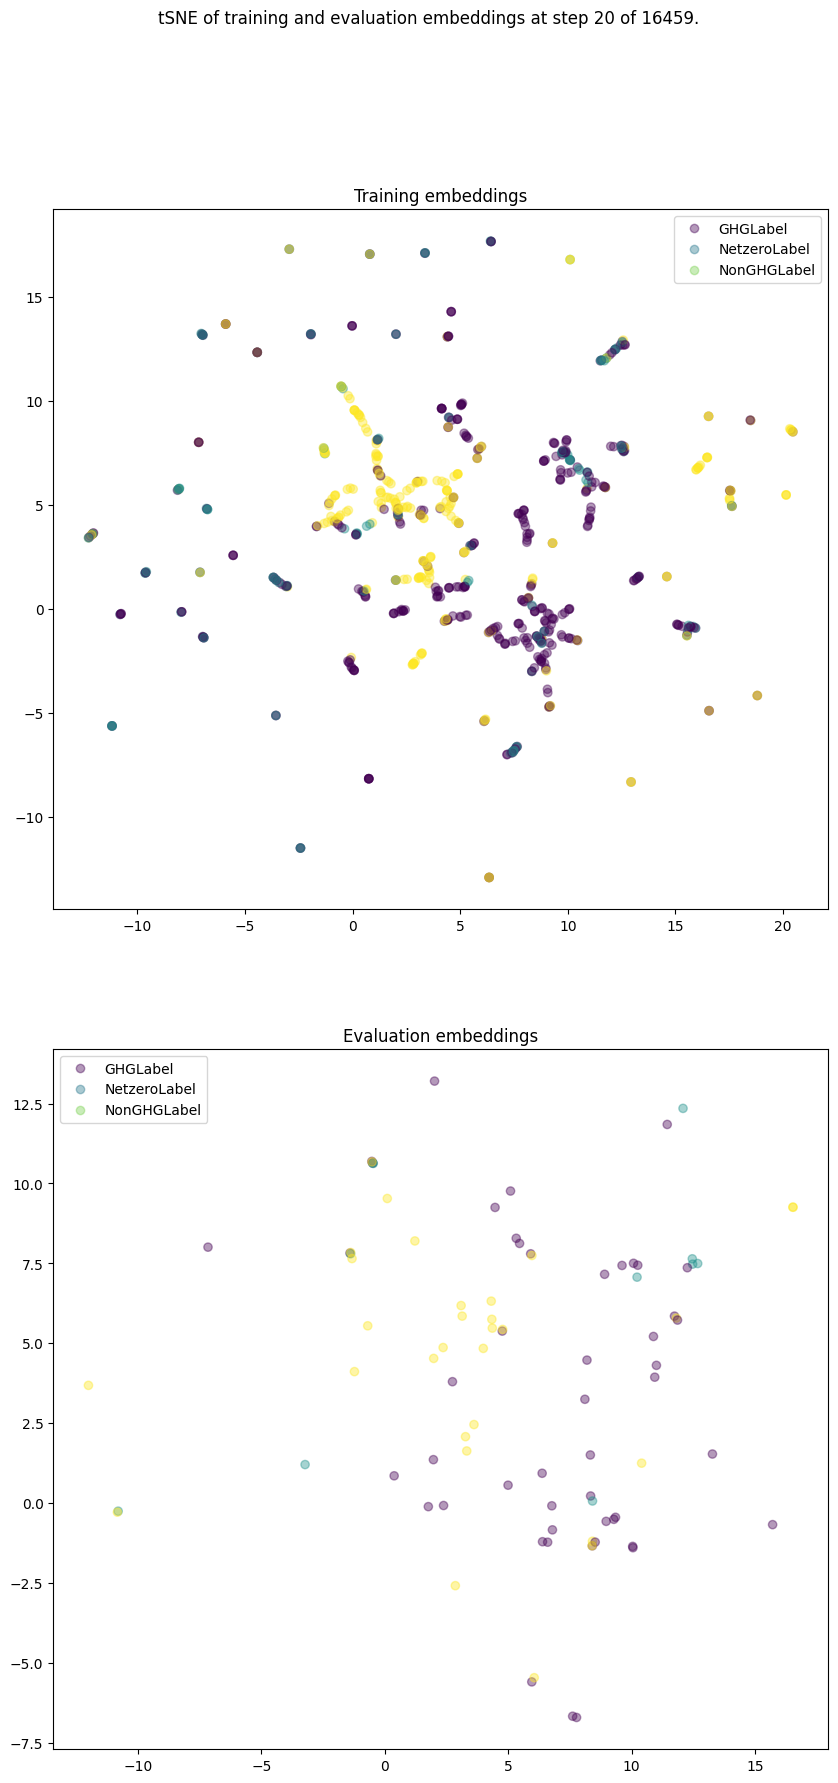

  0%|          | 0/193 [00:00<?, ?it/s]

In [ ]:
# if emebddings visulization are selected in callbacks then you can find the plots in
# folder "embeddings_plots" in root directory.
trainer.train()

In [ ]:
report = pd.DataFrame(trainer.model.model_card_data['eval_lines_list'])
report

,Epoch,Step,Training Loss,Validation Loss
0,0.000030,1,0.2227,-
1,0.151897,5000,0.0150,0.0831
2,0.303794,10000,0.0146,0.0924
3,0.455692,15000,0.0197,0.0827
4,0.607589,20000,0.0031,0.0883
5,0.759486,25000,0.0439,0.0865
6,0.911383,30000,0.0029,0.0914


## Classifier Training

In [ ]:
import warnings
warnings.simplefilter('ignore')
trainer.train_classifier_new(df_train['text'],df_train['label'],df_test['text'],df_test['label'])

In [ ]:
metrics_training = pd.DataFrame(metrics['training'])
metrics_training = metrics_training.add_prefix('training_')
metrics_val = pd.DataFrame(metrics['validation'])
metrics_val  = metrics_val.add_prefix('val_')
metrics_df = pd.concat([metrics_training,metrics_val],axis=1)
display(metrics_df)
cols = list(metrics_df.columns)
cols_filtered = list(filter(lambda x: 'f1' in x, cols))
display(metrics_df[cols_filtered])

In [ ]:
trainer.push_to_hub("ppsingh/SUBTARGET_multilabel_bge")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model_head.pkl:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ppsingh/SUBTARGET_multilabel_bge/commit/5b99b4efddd472012075db697bfdc474e0ec8824', commit_message='Add SetFit model', commit_description='', oid='5b99b4efddd472012075db697bfdc474e0ec8824', pr_url=None, pr_revision=None, pr_num=None)

# Evaluate

In [ ]:
from setfit import SetFitModel

# Download from the 🤗 Hub
model = SetFitModel.from_pretrained("GIZ/SUBTARGET_multilabel_bge", device=device,token=True)

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.85k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config_setfit.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

In [ ]:
import sklearn.metrics as skm
# Run inference
y_pred = model(list(df_test.text))

y_pred = y_pred.tolist()
y_true = list(df_test.label)
cm = skm.multilabel_confusion_matrix(y_true, y_pred)
for i,label in enumerate(label_names):
    print(label)
    print(cm[i],'\n')

GHGLabel
[[25  6]
 [ 3 46]] 

NetzeroLabel
[[67  2]
 [ 0 11]] 

NonGHGLabel
[[47  3]
 [ 2 28]] 



In [ ]:
report = skm.classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.reset_index()
mapping = {str(i):j for i,j in enumerate(label_names)}
df_report['index'] = df_report['index'].map(mapping).fillna(df_report['index'])
df_report.rename(columns = {'index':'label'}, inplace=True)
df_report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,precision,recall,f1-score,support
0,GHGLabel,0.884615,0.938776,0.910891,49.0
1,NetzeroLabel,0.846154,1.000000,0.916667,11.0
2,NonGHGLabel,0.903226,0.933333,0.918033,30.0
3,micro avg,0.885417,0.944444,0.913978,90.0
4,macro avg,0.877998,0.957370,0.915197,90.0
5,weighted avg,0.886118,0.944444,0.913978,90.0
6,samples avg,0.893750,0.922917,0.897083,90.0


In [ ]:
tracker.stop()